# El Niño forecast from recent sea surface temperatures

***
This notebook will provide you guidance on how to access and use the [`COBE-SST 2 and Sea Ice`](https://psl.noaa.gov/data/gridded/data.cobe2.html) datset.

El Niño / Southern Oscillation (ENSO) is the dominant mode of variability that affects the climate on seasonal time scales.  It is measured by the Nino3.4 index, a rolling 3-month average of equatorial Pacific temperatures.  ENSO is an oscillation and is marked by two phases: El Niño, with anomalously warm equatorial Pacific temperatures, and La Niña, with anomlously cold temperatures.

Historically, scientists have classified the intensity of El Niño based on SST anomalies exceeding a pre-selected threshold in a certain region of the equatorial Pacific. The most commonly used region is the Niño 3.4 region, and the most commonly used threshold is a positive SST departure from normal greater than or equal to +0.5°C.

![Niño Regions](https://www.ncei.noaa.gov/monitoring-content/teleconnections/nino-regions.gif)

In this tutorial, we use gridded sea surface temperature covering parts of the Pacific as a predictor for El Niño events.

The first goal is to select an area including the Niño 3 and 4 regions and extending it a bit further to the North and South. For this area, monthly averages of air temperature will be computed.

The second goal is to train and evaluate a neural network to predict future sea surface temperature from previous dynamics in sea surface temperature.

This tutorial is partly based on the tutorial "Forecasting the El Niño / Southern Oscillation with Machine Learning" from [Climate Change AI](https://www.climatechange.ai/tutorials?type=Climate+Prediction)
***

## What you will learn:

* how to access and preview the dataset
* select and reduce the data
* set up and train a neural network
* plot the results

## Installations for Google Colab

Install required packages for Google Colab.

In [1]:
!pip install cartopy==0.21.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 15.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 34.8 MB/s eta 0:00:00
  Created wheel for cartopy: filename=Cartopy-0.21.0-cp310-cp310-linux_x86_64.whl size=11080983 sha256=f1d3f9c6a2fcb1369e8472d492371628496cc2002c6764a5505f69a03870103c
  Stored in directory: /root/.cache/pip/wheels/7f/23/9e/487147fae9611dd47b310c62ad19d466013f45f7cbb69f6fd8
Successfully built cartopy
  Attempting uninstall: shapely
    Found existing installation: shapely 2.0.3
    Uninstalling shapely-2.0.3:
      Successfully uninstalled shapely-2.0.3


## Software Requirements

Load required packages.

In [2]:
%matplotlib inline
import xarray as xr
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import sklearn
import sklearn.ensemble
import scipy.stats
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import xarray as xr
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from cartopy import crs as ccrs
import sklearn
import sklearn.ensemble
import scipy.stats
from sklearn.model_selection import train_test_split
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from scipy.stats import pearsonr
from sklearn.metrics import mean_squared_error

## Data access and preview
***

Download of historical gridded sea surface temperatures from [https://psl.noaa.gov/data/gridded/data.cobe2.html](https://psl.noaa.gov/data/gridded/data.cobe2.html):

***

In [3]:
!wget https://downloads.psl.noaa.gov/Datasets/COBE2/sst.mon.mean.nc

--2024-03-16 18:44:04--  https://downloads.psl.noaa.gov/Datasets/COBE2/sst.mon.mean.nc
Resolving downloads.psl.noaa.gov (downloads.psl.noaa.gov)... 140.172.38.86
Connecting to downloads.psl.noaa.gov (downloads.psl.noaa.gov)|140.172.38.86|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 541971483 (517M) [application/x-netcdf]
Saving to: ‘sst.mon.mean.nc’

sst.mon.mean.nc     100%[===================>] 516.86M  37.6MB/s    in 15s     

2024-03-16 18:44:19 (35.1 MB/s) - ‘sst.mon.mean.nc’ saved [541971483/541971483]



Open the downloaded NetCDF as xarray, only metadata will be loaded.

In [4]:
ds = xr.open_dataset("sst.mon.mean.nc")
ds

<xarray.Dataset>
Dimensions:  (lat: 180, lon: 360, time: 2090)
Coordinates:
  * lat      (lat) float32 89.5 88.5 87.5 86.5 85.5 ... -86.5 -87.5 -88.5 -89.5
  * lon      (lon) float32 0.5 1.5 2.5 3.5 4.5 ... 355.5 356.5 357.5 358.5 359.5
  * time     (time) datetime64[ns] 1850-01-01 1850-02-01 ... 2024-02-01
Data variables:
    sst      (time, lat, lon) float32 ...
Attributes:
    title:            created 12/2013 from data provided by JRA
    history:          Created 12/2012 from data obtained from JRA by ESRL/PSD
    platform:         Analyses
    citation:         Hirahara, S., Ishii, M., and Y. Fukuda,2014: Centennial...
    institution:      NOAA ESRL/PSD
    Conventions:      CF-1.2
    dataset_title:    COBE-SST2 Sea Surface Temperature and Ice
    original_source:  https://climate.mri-jma.go.jp/pub/ocean/cobe-sst2/
    References:       http://www.psl.noaa.gov/data/gridded/cobe2.html

## Working with data

The structure of a workflow that uses an xarray looks like this:
1. data selection
2. data reduction
3. optional visualization

## Sea surface temperature anomaly

### 1. Data selection

From the original dataset we extract the sea surface temperature (variable `sst`) and perform a geographical selection corresponding to the Pacific equator area Niño 3.4. This greatly reduces the amount of data that will be loaded to memory.

Note that latitudes are decreasing from 90 to -90 degrees and longitudes are increasing from 0 to 360 degrees. The geographic slices need to be defined accordingly.

In [5]:
# small area for faster processing
#ds_pacific_area = ds.sel(**{"lat": slice(5, -5), "lon": slice(190, 240)})

# larger area for better predictions
ds_pacific_area = ds.sel(**{"lat": slice(10, -10), "lon": slice(160, 270)})
ds_pacific_area

<xarray.Dataset>
Dimensions:  (lat: 20, lon: 110, time: 2090)
Coordinates:
  * lat      (lat) float32 9.5 8.5 7.5 6.5 5.5 4.5 ... -5.5 -6.5 -7.5 -8.5 -9.5
  * lon      (lon) float32 160.5 161.5 162.5 163.5 ... 266.5 267.5 268.5 269.5
  * time     (time) datetime64[ns] 1850-01-01 1850-02-01 ... 2024-02-01
Data variables:
    sst      (time, lat, lon) float32 ...
Attributes:
    title:            created 12/2013 from data provided by JRA
    history:          Created 12/2012 from data obtained from JRA by ESRL/PSD
    platform:         Analyses
    citation:         Hirahara, S., Ishii, M., and Y. Fukuda,2014: Centennial...
    institution:      NOAA ESRL/PSD
    Conventions:      CF-1.2
    dataset_title:    COBE-SST2 Sea Surface Temperature and Ice
    original_source:  https://climate.mri-jma.go.jp/pub/ocean/cobe-sst2/
    References:       http://www.psl.noaa.gov/data/gridded/cobe2.html

At this point, no data has been loaded in memory.

Mean temperature over the whole reference period:

In [6]:
ds_pacific_area_mean = ds_pacific_area.mean(dim="time")

After that, we can compute the monthly temperature anomalies in the same area. Calling `compute()` on the result will trigger the computation, needed to load the data to the neural network.

We can mesure the time it takes, should be about 30 sec:

In [7]:
%%time

ds_pacific_area_monthly_anomaly = ds_pacific_area - ds_pacific_area_mean
ds_pacific_area_monthly_anomaly = ds_pacific_area_monthly_anomaly.compute()
ds_pacific_area_monthly_anomaly

CPU times: user 19.1 ms, sys: 840 µs, total: 19.9 ms
Wall time: 20.9 ms


<xarray.Dataset>
Dimensions:  (lat: 20, lon: 110, time: 2090)
Coordinates:
  * lat      (lat) float32 9.5 8.5 7.5 6.5 5.5 4.5 ... -5.5 -6.5 -7.5 -8.5 -9.5
  * lon      (lon) float32 160.5 161.5 162.5 163.5 ... 266.5 267.5 268.5 269.5
  * time     (time) datetime64[ns] 1850-01-01 1850-02-01 ... 2024-02-01
Data variables:
    sst      (time, lat, lon) float32 -0.6107 -0.6453 -0.6708 ... 2.979 3.138

## 1997-1998 El Niño event

We further select only the time span realative to the El Niño event, and compute the mean temperature anomaly:

In [ ]:
ds_pacific_area_monthly_anomaly_1997_1998 = ds_pacific_area_monthly_anomaly.sel(time=slice("1997-04", "1998-04"))
ds_pacific_area_monthly_anomaly_1997_1998_mean = ds_pacific_area_monthly_anomaly_1997_1998.mean(dim="time")
ds_pacific_area_monthly_anomaly_1997_1998_mean

<xarray.Dataset>
Dimensions:  (lat: 20, lon: 110)
Coordinates:
  * lat      (lat) float32 9.5 8.5 7.5 6.5 5.5 4.5 ... -5.5 -6.5 -7.5 -8.5 -9.5
  * lon      (lon) float32 160.5 161.5 162.5 163.5 ... 266.5 267.5 268.5 269.5
Data variables:
    sst      (lat, lon) float32 -0.05481 -0.0718 -0.08331 ... 2.314 2.402 2.5

### 3. Visualization
We can plot the mean temperature anomaly during the El Niño Event on a map.

**! This crashes the Google Colab session !**

In [ ]:
ds_plt = ds_pacific_area_monthly_anomaly_1997_1998_mean.sst.compute()

_, ax = plt.subplots(
    figsize=(10, 8),
    subplot_kw={"projection":  ccrs.Miller()},
)
ds_plt.plot(
    ax=ax,
    cmap="Blues",
    transform=ccrs.PlateCarree(),
    cbar_kwargs={"orientation": "horizontal", "pad": 0.05, "aspect": 40, "label": "Sea Surface temperature anomaly [C]"},
)
ax.coastlines()
ax.set_title("El Nino event (1997-1998)")
plt.show()

## Data preparation for AI

We have already computed monthly temperature anomalies from the COBE 2 SST dataset and now need ground truth observations to train a network.

### Observed sea surface temperature anomalies for the Nino3.4 area.

Original data for Equatorial Pacific Sea Surface Temperatures (SST) are available [here](https://www.ncei.noaa.gov/access/monitoring/enso/sst) as a plain text file containing absolute values and anomalies for the Nino3.4 region.

Download observations for Jan 1950 to recent:

In [8]:
!wget https://www.cpc.ncep.noaa.gov/data/indices/oni.ascii.txt

--2024-03-16 18:50:49--  https://www.cpc.ncep.noaa.gov/data/indices/oni.ascii.txt
Resolving www.cpc.ncep.noaa.gov (www.cpc.ncep.noaa.gov)... 140.90.101.19
Connecting to www.cpc.ncep.noaa.gov (www.cpc.ncep.noaa.gov)|140.90.101.19|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 22250 (22K) [text/plain]
Saving to: ‘oni.ascii.txt’

oni.ascii.txt       100%[===================>]  21.73K  --.-KB/s    in 0.01s   

2024-03-16 18:50:49 (1.49 MB/s) - ‘oni.ascii.txt’ saved [22250/22250]



Helper functions to manage input data:

In [9]:
# Scaffold code to load in data.  This code cell is mostly data wrangling

def load_enso_indices():
  """
  Reads in the txt data file to output a pandas Series of ENSO vals

  outputs
  -------

    pd.Series : monthly ENSO values starting from 1950-01-01
  """
  with open('oni.ascii.txt') as f:
    line = f.readline()
    enso_vals = []
    first = True
    while line:
        enso_val = line.split()[-1]
        if first:
            first = False
        else:
            enso_vals.append(float(enso_val))
        line = f.readline()

  enso_vals = pd.Series(enso_vals)
  enso_vals.index = pd.date_range('1950-01-01',freq='MS',
                                  periods=len(enso_vals))
  enso_vals.index = pd.to_datetime(enso_vals.index)

  return enso_vals


def assemble_predictors_predictands(ds, start_date, end_date, lead_time,
                                    data_format,
                                    num_input_time_steps=1,
                                    use_pca=False, n_components=32):
  """
  inputs
  ------

      ds                xarray : input xarray dataset
      start_date           str : the start date from which to extract sst
      end_date             str : the end date
      lead_time            str : the number of months between each sst
                                 value and the target Nino3.4 Index
      data_format          str : 'spatial' or 'flatten'. 'spatial' preserves
                                 the lat/lon dimensions and returns an
                                 array of shape (num_samples, num_input_time_steps,
                                 lat, lon).  'flatten' returns an array of shape
                                 (num_samples, num_input_time_steps*lat*lon)
      num_input_time_steps int : the number of time steps to use for each
                                 predictor sample
      use_pca             bool : whether or not to apply principal components
                                 analysis to the sst field
      n_components         int : the number of components to use for PCA

  outputs
  -------
      Returns a tuple of the predictors (np array of sst temperature anomalies)
      and the predictands (np array the ENSO index at the specified lead time).

  """

  sst = ds.sel(time=slice(start_date, end_date))

  num_samples = sst.shape[0]
  # sst is a (num_samples, lat, lon) array
  # the line below converts it to (num_samples, num_input_time_steps, lat, lon)
  sst = np.stack([sst.values[n-num_input_time_steps:n] for n in range(num_input_time_steps,
                                                              num_samples+1)])
  # CHALLENGE: CAN YOU IMPLEMENT THE ABOVE LINE WITHOUT A FOR LOOP?
  num_samples = sst.shape[0]

  sst[np.isnan(sst)] = 0
  if data_format=='flatten':
    # sst is a 3D array: (time_steps, lat, lon)
    # in this tutorial, we will not be using ML models that take
    # advantage of the spatial nature of global temperature
    # therefore, we reshape sst into a 2D array: (time_steps, lat*lon)
    # (At each time step, there are lat*lon predictors)
    sst = sst.reshape(num_samples, -1)


    # Use Principal Components Analysis, also called
    # Empirical Orthogonal Functions, to reduce the
    # dimensionality of the array
    if use_pca:
      pca = sklearn.decomposition.PCA(n_components=n_components)
      pca.fit(sst)
      X = pca.transform(sst)
    else:
      X = sst
  else: # data_format=='spatial'
    X = sst

  start_date_plus_lead = pd.to_datetime(start_date) + \
                        pd.DateOffset(months=lead_time+num_input_time_steps-1)
  end_date_plus_lead = pd.to_datetime(end_date) + \
                      pd.DateOffset(months=lead_time)

  y = load_enso_indices()[slice(start_date_plus_lead, end_date_plus_lead)]

  return X.astype(np.float32), y.astype(np.float32)


class ENSODataset(Dataset):
    def __init__(self, predictors, predictands):
        self.predictors = predictors
        self.predictands = predictands
        assert self.predictors.shape[0] == self.predictands.shape[0], \
               "The number of predictors must equal the number of predictands!"

    def __len__(self):
        return self.predictors.shape[0]

    def __getitem__(self, idx):
        return self.predictors[idx], self.predictands[idx]


def plot_nino_time_series(y, predictions, title):
  """
  inputs
  ------
    y           pd.Series : time series of the true Nino index
    predictions np.array  : time series of the predicted Nino index (same
                            length and time as y)
    tile                  : the title of the plot

  outputs
  -------
    None.  Displays the plot
  """
  predictions = pd.Series(predictions, index=y.index)
  predictions = predictions.sort_index()
  y = y.sort_index()

  plt.plot(y, label='Ground Truth')
  plt.plot(predictions, '--', label='AI Predictions')
  plt.legend(loc='best')
  plt.title(title)
  plt.ylabel('Nino3.4 Index')
  plt.xlabel('Date')
  plt.show()
  plt.close()


## Train A Simple Convolutional Neural Network to Forecast ENSO

Let's define a simple convolutional neural network architecture.  This architecture has one convolutional layer, followed by a pooling layer, followed by another convolutional layer, followed by three fully connected layers.  The output of the final fully connected layer is a 1-D array, since we are trying to forecast one value: the target ENSO index.

### Define the network

In [29]:
class CNN(nn.Module):
    def __init__(self, num_input_time_steps=1, print_feature_dimension=False):
        """
        inputs
        -------
            num_input_time_steps        (int) : the number of input time
                                                steps in the predictor
            print_feature_dimension    (bool) : whether or not to print
                                                out the dimension of the features
                                                extracted from the conv layers
        """
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(num_input_time_steps, 12, 3)
        self.pool = nn.MaxPool2d(3, 3)
        self.conv2 = nn.Conv2d(12, 10, 3)
        self.print_layer = Print()

        # TIP: print out the dimension of the extracted features from
        # the conv layers for setting the dimension of the linear layer!
        # Using the print_layer, we find that the dimensions are
        # (batch_size, 32, 18, 108)
        self.fc1 = nn.Linear(10 * 1 * 11, 512)
        self.fc2 = nn.Linear(512, 32)
        self.fc3 = nn.Linear(32, 1)
        self.print_feature_dimension = print_feature_dimension

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        if self.print_feature_dimension:
          x = self.print_layer(x)
        # adjust to dimensions of fc1
        x = x.view(-1, 10 * 1 * 11)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

class Print(nn.Module):
    """
    This class prints out the size of the features
    """
    def forward(self, x):
        print(x.size())
        return x

Next, let's define a method that trains our neural network.

In [11]:
def train_network(net, criterion, optimizer, trainloader, testloader,
                  experiment_name, num_epochs=40):
  """
  inputs
  ------

      net               (nn.Module)   : the neural network architecture
      criterion         (nn)          : the loss function (i.e. root mean squared error)
      optimizer         (torch.optim) : the optimizer to use update the neural network
                                        architecture to minimize the loss function
      trainloader       (torch.utils.data.DataLoader): dataloader that loads the
                                        predictors and predictands
                                        for the train dataset
      testloader        (torch.utils.data. DataLoader): dataloader that loads the
                                        predictors and predictands
                                        for the test dataset
  outputs
  -------
      predictions (np.array), and saves the trained neural network as a .pt file
  """
  device = "cuda:0" if torch.cuda.is_available() else "cpu"
  net = net.to(device)
  best_loss = np.infty
  train_losses, test_losses = [], []

  for epoch in range(num_epochs):
    for mode, data_loader in [('train', trainloader), ('test', testloader)]:
      # Set the model to train mode to allow its weights to be updated
      # while training
      if mode == 'train':
        net.train()

      # Set the model to eval model to prevent its weights from being updated
      # while testing
      elif mode == 'test':
        net.eval()

      running_loss = 0.0
      for i, data in enumerate(data_loader):
          # get a mini-batch of predictors and predictands
          batch_predictors, batch_predictands = data
          batch_predictands = batch_predictands.to(device)
          batch_predictors = batch_predictors.to(device)

          # zero the parameter gradients
          optimizer.zero_grad()

          # calculate the predictions of the current neural network
          predictions = net(batch_predictors).squeeze()

          # quantify the quality of the predictions using a
          # loss function (aka criterion) that is differentiable
          loss = criterion(predictions, batch_predictands)

          if mode == 'train':
            # the 'backward pass: calculates the gradients of each weight
            # of the neural network with respect to the loss
            loss.backward()

            # the optimizer updates the weights of the neural network
            # based on the gradients calculated above and the choice
            # of optimization algorithm
            optimizer.step()

          # Save the model weights that have the best performance!

          running_loss += loss.item()

      if running_loss < best_loss and mode == 'test':
          best_loss = running_loss
          torch.save(net, '{}.pt'.format(experiment_name))
      print('{} Set: Epoch {:02d}. loss: {:3f}'.format(mode, epoch+1, \
                                            running_loss/len(data_loader)))
      if mode == 'train':
          train_losses.append(running_loss/len(data_loader))
      else:
          test_losses.append(running_loss/len(data_loader))

  net = torch.load('{}.pt'.format(experiment_name))
  net.eval()
  net.to(device)

  # the remainder of this function calculates the predictions of the best
  # saved model
  predictions = np.asarray([])
  for i, data in enumerate(testloader):
    batch_predictors, batch_predictands = data
    batch_predictands = batch_predictands.to(device)
    batch_predictors = batch_predictors.to(device)

    batch_predictions = net(batch_predictors).squeeze()
    # Edge case: if there is 1 item in the batch, batch_predictions becomes a float
    # not a Tensor. the if statement below converts it to a Tensor
    # so that it is compatible with np.concatenate
    if len(batch_predictions.size()) == 0:
      batch_predictions = torch.Tensor([batch_predictions])
    predictions = np.concatenate([predictions, batch_predictions.detach().cpu().numpy()])
  return predictions, train_losses, test_losses


### Actual training

Prepare data for the network and train it.

Important settings are the number of input time steps in months (more is better) and the lead time, i.e. how many months into the future from the current time steps onwards should the predictions be made (more is more difficult).

The earliest possible start date is 1950-01-01. The latest possible end date is determined by the latest common date of the input data which are continuously updated.

In [30]:
%%time

# Assemble numpy arrays corresponding to predictors and predictands
train_start_date = '1950-01-01'
train_end_date = '2016-12-31'

test_start_date = '2017-01-01'
test_end_date = '2023-10-31'

num_input_time_steps = 6
lead_time = 2
train_predictors, train_predictands = assemble_predictors_predictands(ds_pacific_area_monthly_anomaly["sst"],
                                                                      train_start_date, train_end_date,
                                                                      lead_time, 'spatial',
                                                                      num_input_time_steps=num_input_time_steps)
print("train_predictors: %d" % train_predictors.shape[0])
print("train_predictands: %d" % train_predictands.shape[0])
test_predictors, test_predictands = assemble_predictors_predictands(ds_pacific_area_monthly_anomaly["sst"],
                                                                    test_start_date, test_end_date,
                                                                    lead_time, 'spatial',
                                                                    num_input_time_steps=num_input_time_steps)
print("test_predictors: %d" % test_predictors.shape[0])
print("test_predictands: %d" % test_predictands.shape[0])

# Convert the numpy ararys into ENSODataset, which is a subset of the
# torch.utils.data.Dataset class.  This class is compatible with
# the torch dataloader, which allows for data loading for a CNN
train_dataset = ENSODataset(train_predictors, train_predictands)
test_dataset = ENSODataset(test_predictors, test_predictands)

# Create a torch.utils.data.DataLoader from the ENSODatasets() created earlier!
# the similarity between the name DataLoader and Dataset in the pytorch API is unfortunate...
trainloader = DataLoader(train_dataset, batch_size=10)
testloader = DataLoader(test_dataset, batch_size=10)
net = CNN(num_input_time_steps=num_input_time_steps, print_feature_dimension=False)
optimizer = optim.Adam(net.parameters(), lr=0.0001)

# train the model and make predictions for the test time period
experiment_name = "twolayerCNN_{}_{}".format(train_start_date, train_end_date)
predictions, train_losses, test_losses = train_network(net, nn.MSELoss(),
                  optimizer, trainloader, testloader, experiment_name, num_epochs=50)

train_predictors: 799
train_predictands: 799
test_predictors: 77
test_predictands: 77
train Set: Epoch 01. loss: 0.640606
test Set: Epoch 01. loss: 0.564544
train Set: Epoch 02. loss: 0.419034
test Set: Epoch 02. loss: 0.351332
train Set: Epoch 03. loss: 0.295392
test Set: Epoch 03. loss: 0.294906
train Set: Epoch 04. loss: 0.247344
test Set: Epoch 04. loss: 0.252498
train Set: Epoch 05. loss: 0.218576
test Set: Epoch 05. loss: 0.228497
train Set: Epoch 06. loss: 0.199566
test Set: Epoch 06. loss: 0.216239
train Set: Epoch 07. loss: 0.187309
test Set: Epoch 07. loss: 0.202884
train Set: Epoch 08. loss: 0.177604
test Set: Epoch 08. loss: 0.193891
train Set: Epoch 09. loss: 0.169549
test Set: Epoch 09. loss: 0.187096
train Set: Epoch 10. loss: 0.162897
test Set: Epoch 10. loss: 0.181147
train Set: Epoch 11. loss: 0.157154
test Set: Epoch 11. loss: 0.176558
train Set: Epoch 12. loss: 0.152043
test Set: Epoch 12. loss: 0.172567
train Set: Epoch 13. loss: 0.147773
test Set: Epoch 13. loss: 

## Results of NN training

Plot train and test losses:

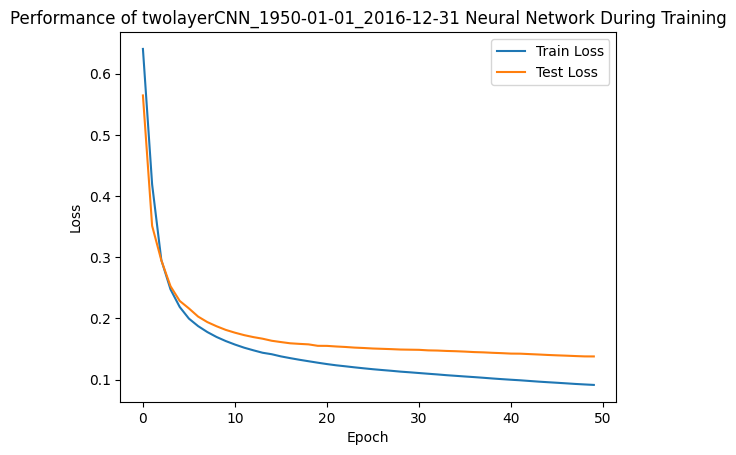

In [31]:
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Performance of {} Neural Network During Training'.format(experiment_name))
plt.legend(loc='best')
plt.show()

If test loss does not look satisfactory, try reducing the number of parameters of the network. You could define your own network architecture, which uses a different number of parameters.

Alternatively, try increasing the number of training samples by using a longer time period or a larger area.

Show predictions:

RMSE: 0.37


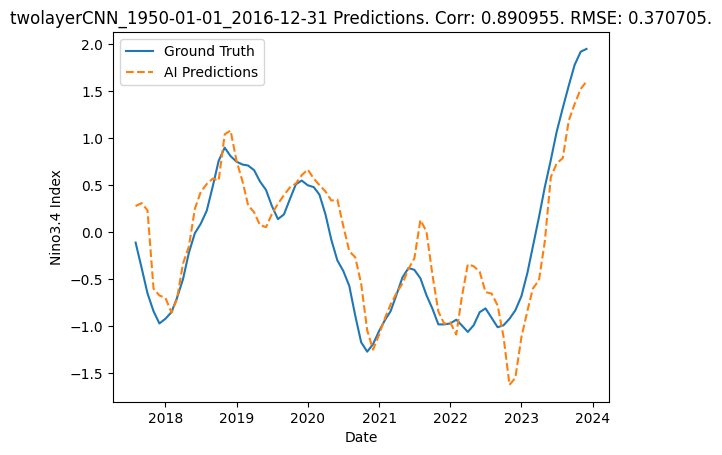

In [32]:
corr, _ = pearsonr(test_predictands, predictions)
rmse = mean_squared_error(test_predictands, predictions) ** 0.5

print("RMSE: {:.2f}".format(rmse))
plot_nino_time_series(test_predictands, predictions, '{} Predictions. Corr: {:3f}. RMSE: {:3f}.'.format(experiment_name,
                                                                      corr, rmse))